# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

In [2]:
ruta_proyecto = 'C:/Users/mig_g/OneDrive/PROYECTOS_MIGUEL/SCORING_RIESGOS'
ruta_proyecto

'C:/Users/mig_g/OneDrive/PROYECTOS_MIGUEL/SCORING_RIESGOS'

2.- Nombrar los ficheros de datos.

In [3]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargar los datos.

In [4]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Conclusiones de las fases anteriores:

Modificar con pandas/numpy:

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda agrupar ANY, NONE y OTHER
* En finalidad agrupar renewable_energy, educational y  wedding en 'otros'

Modificar con scikit learn:

* La variable descripcion se puede tratar con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN DE VARIABLES Y TRANSFORMACIONES CON PANDAS

### Target para el modelo PD

**PROBABILIDAD DE QUE EL CLIENTE GENERE UN IMPAGO (MODELO CLASIFICACION)**

Crear la target a partir de estado

In [5]:
cat.estado.value_counts()

Fully Paid                                             66221
Current                                                54099
Charged Off                                            16469
Late (31-120 days)                                      1309
In Grace Period                                          538
Late (16-30 days)                                        272
Does not meet the credit policy. Status:Fully Paid       120
Does not meet the credit policy. Status:Charged Off       51
Default                                                    2
Name: estado, dtype: int64

In [6]:
# todos los clientes cuyo estado se encuentre en cualquiera de estos: 'Charged Off','Does not meet the credit policy. Status:Charged Off','Default'
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,desconocido,debt_consolidation,36 months,Current,0
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,desconocido,debt_consolidation,36 months,Charged Off,1
46641215,Banker,5 years,Verified,A,RENT,desconocido,debt_consolidation,36 months,Fully Paid,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,desconocido,credit_card,60 months,Current,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,0
...,...,...,...,...,...,...,...,...,...,...
129396054,Field Manager,10+ years,Source Verified,D,OWN,desconocido,debt_consolidation,60 months,Current,0
119242742,desconocido,desconocido,Source Verified,C,RENT,desconocido,debt_consolidation,36 months,Late (31-120 days),0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,desconocido,other,36 months,Current,0


In [7]:
cat.drop(columns='estado',inplace=True) # eliminamos ahora la variable estado como predictora

### Target para el modelo EAD

**target para el modelo de regresion de EAD**

Será el porcentaje del principal que no había sido amortizado.

Por tanto: pendiente / principal

Primero tenemos que construir el pendiente como el principal menos el amortizado.

In [8]:
num['pendiente'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente
id_cliente,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49


In [9]:
num['target_ead'] = num.pendiente / num.principal # calculamos pendiente en %
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149


### Target para el modelo LGD

Será el porcentaje del pendiente que NO se recupera en caso de impago.

Por tanto: 1 - (imp_recuperado / pendiente)

In [10]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente) # calculamos lo que NO SE PUDO RECUPERAR
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,NaN
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Los nulos se producen cuando el pendiente es cero. Por tanto se imputaran por ceros.

In [11]:
num['target_lgd'].fillna(0,inplace=True)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Comprobamos las targets creadas.

In [12]:
cat['target_pd'].mean()

0.11879408402297942

In [13]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139081.0,0.337345,0.368936,-0.000032,0.0,0.130220,0.725145,1.0
target_lgd,139081.0,0.508902,0.490380,-0.275957,0.0,0.850708,1.000000,1.0


Limitamos para garantizar que siempre estén entre 0 y 1

In [14]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [15]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139081.0,0.337345,0.368936,0.0,0.0,0.130220,0.725145,1.0
target_lgd,139081.0,0.508930,0.490348,0.0,0.0,0.850708,1.000000,1.0


### Resto de variables

num_meses_desde_ult_retraso

revisando la relación con la target_pd

In [16]:
# TEMPORAL
temp = num[['num_meses_desde_ult_retraso']].copy() 
temp

,num_meses_desde_ult_retraso
id_cliente,
137387967,10.0
4798121,0.0
46641215,0.0
87998444,0.0
132883631,16.0
...,...
129396054,0.0
119242742,0.0
121031962,6.0


In [17]:
# DISCRETIZAMOS LA VARIABLE
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
# AGREGAMOS DE LAS CATEGORICAS LA TARGET_PD 
temp['target'] = cat['target_pd'] 

calcular cuántos casos de la variable objetivo (target) hay en promedio dentro de cada intervalo 

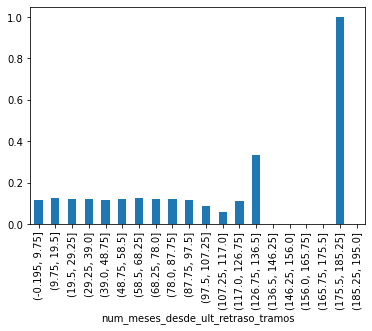

In [18]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

**NO PARECE SER PREDICTIVA DEBIDO A QUE NO HAY MUCHA DIFERENCIA ENTRE LOS CORTES, SALVO UNA DONDE HAY PROBABILIDAD DE 100% DE IMPAGO**

La distribución de la target en esta variable no genera confianza, así que se procede a descartar

In [19]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

En vivienda agrupar ANY, NONE y OTHER se pueden agrupar dentro de la categoria mayoritaria

In [20]:
cat.vivienda.value_counts()

MORTGAGE    68173
RENT        55314
OWN         15520
ANY            57
OTHER          16
NONE            1
Name: vivienda, dtype: int64

In [21]:
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [22]:
cat.vivienda.value_counts()

MORTGAGE    68247
RENT        55314
OWN         15520
Name: vivienda, dtype: int64

En finalidad agrupar renewable_energy, educational y wedding en 'otros'

In [23]:
cat.finalidad.value_counts()

debt_consolidation    79014
credit_card           31490
home_improvement       9023
other                  8599
major_purchase         3129
medical                1668
small_business         1564
car                    1434
moving                 1012
vacation                987
house                   907
wedding                 152
renewable_energy         74
educational              28
Name: finalidad, dtype: int64

In [24]:
# creamos una categoria 'otros' para agrupar las minoritarias
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'otros')

In [25]:
cat.finalidad.value_counts()

debt_consolidation    79014
credit_card           31490
home_improvement       9023
other                  8599
major_purchase         3129
medical                1668
small_business         1564
car                    1434
moving                 1012
vacation                987
house                   907
otros                   254
Name: finalidad, dtype: int64

## TRANSFORMACIÓN DE CATEGÓRICAS

### One Hot Encoding

#### Variables a aplicar OHE

In [26]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

#### Instanciar

In [27]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [28]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

#### Guardar como dataframe

In [29]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables a aplicar OE

In [30]:
var_oe = ['antigüedad_empleo','rating']

#### Orden de los valores de las variables

In [31]:
#Orden de la primera variable
orden_antigüedad_empleo = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
                           '5 years','6 years','7 years','8 years','9 years','10+ years']

#Orden de la segunda variable
orden_rating = ['A','B','C','D','E','F','G'] # 0 PARA CLIENTES BUENOS Y 1 LOS CLIENTES MALOS

#### Instanciar

In [32]:
oe = OrdinalEncoder(categories = [orden_antigüedad_empleo,orden_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Entrenar y aplicar

In [33]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [34]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

## TRANSFORMACIÓN DE NUMÉRICAS

### Binarizar variables

#### Variables a binarizar

In [35]:
var_bin = ['num_derogatorios']

#### Instanciar

In [36]:
bin = Binarizer(threshold=0)

#### Entrenar y aplicar

In [37]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [38]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

### Con Min-Max

Unificar los datasets a reescalar.

In [39]:
num_escalar = num[['ingresos',
                  'dti',
                  'num_lineas_credito',
                  'porc_uso_revolving',
                  'principal',
                  'tipo_interes',
                  'imp_cuota']].reset_index(drop=True)

In [40]:
df_res = pd.concat([cat_oe,num_escalar], axis=1)

#### Variables a reescalar con Min-Max

In [41]:
var_mms = df_res.columns

#### Instanciar

In [42]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [43]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [44]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

## UNIFICAR DATASETS

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de PD

In [45]:
incluir_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de PD

In [46]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [47]:
df_pd.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de EAD

In [48]:
incluir_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Unir todos los dataframes en el tablón analítico para el modelo de EAD

In [49]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [50]:
df_ead.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de LGD

In [51]:
incluir_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de LGD

In [52]:
df_lgd = pd.concat(incluir_lgd, axis = 1)

In [53]:
df_lgd.set_index('id_cliente',inplace=True)

## GUARDAR DATASETS TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [54]:
#Definir los nombres de los archivos
ruta_df_tablon_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_pd.pickle'
ruta_df_tablon_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_ead.pickle'
ruta_df_tablon_lgd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_lgd.pickle'

In [55]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_tablon_pd)
df_ead.to_pickle(ruta_df_tablon_ead)
df_lgd.to_pickle(ruta_df_tablon_lgd)

Otras Conclusiones que vale señalar:
    
Se probaron algunos escenarios con la variable **porc_tarjetas_75p**

* No incluirla
* Incluirla (la variable original sin modificarla)
* Discretizarla y crear una nueva variable categorica

Estos escenarios fueron probados usando regresion logistica para un modelo de clasificacion de PROBABILITY OF DEFAULT que se explica en la siguiente fase y evaluando con la metrica "ROC AUC"

Tambien se probó:
* Incluirla (la variable original sin modificarla) usando HistGradientBoostingRegressor para un modelo de regresion que tambien se explica mas adelante y evaluando con la metrica "mean absolute percentage error"

Despues de probar esos escenarios incluyendo la variable numérica original o su versión discretizada vi que no aportan una mejora significativa en el modelo en comparación con el modelo que ignoraba completamente esta variable. Por ello es que decidí no incluir esta variable